##Using Probabilistic programming to find inflection point in Arsenal's recent history

In [12]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="white", context="talk")

In [362]:
engDf = pd.read_csv('data/engsoccerdata2.csv', parse_dates=['Date'])

In [470]:
engDf.head()

,Date,Season,home,visitor,FT,hgoal,vgoal,division,tier,totgoal,goaldif,result
0,1888-12-15,1888,Accrington F.C.,Aston Villa,1-1,1,1,1,1,2,0,D
1,1889-01-19,1888,Accrington F.C.,Blackburn Rovers,0-2,0,2,1,1,2,-2,A
2,1889-03-23,1888,Accrington F.C.,Bolton Wanderers,2-3,2,3,1,1,5,-1,A
3,1888-12-01,1888,Accrington F.C.,Burnley,5-1,5,1,1,1,6,4,H
4,1888-10-13,1888,Accrington F.C.,Derby County,6-2,6,2,1,1,8,4,H


In [471]:
arsenalDf = engDf[(engDf.visitor.isin(['Arsenal'])) | (engDf.home.isin(['Arsenal']))]
arsenalDf = arsenalDf.sort(['Date'])

In [472]:
arsenalDf.tail()

,Date,Season,home,visitor,FT,hgoal,vgoal,division,tier,totgoal,goaldif,result
188409,2015-05-04,2014,Hull City,Arsenal,1-3,1,3,1,1,4,-2,A
188419,2015-05-11,2014,Arsenal,Swansea City,0-1,0,1,1,1,1,-1,A
188428,2015-05-17,2014,Manchester United,Arsenal,1-1,1,1,1,1,2,0,D
188389,2015-05-20,2014,Arsenal,Sunderland,0-0,0,0,1,1,0,0,D
188430,2015-05-24,2014,Arsenal,West Bromwich Albion,4-1,4,1,1,1,5,3,H


In [473]:
def getArsenalGoalDiff(row):
    goalDiff = 0
    if row['home'] == 'Arsenal':
        goalDiff = row.hgoal - row.vgoal
    else:
        goalDiff = row.vgoal - row.hgoal
    return goalDiff

def getArsenalGoalScored(row):
    goalScored = 0
    if row['home'] == 'Arsenal':
        goalScored = row.hgoal
    else:
        goalScored = row.vgoal
    return goalScored

def getArsenalGoalConced(row):
    goalScored = 0
    if row['home'] == 'Arsenal':
        goalScored = row.vgoal
    else:
        goalScored = row.hgoal
    return goalScored

arsenalDf['gdiff'] = arsenalDf.apply(lambda x: getArsenalGoalDiff(x), axis=1)
arsenalDf['gscored'] = arsenalDf.apply(lambda x: getArsenalGoalScored(x), axis=1)
arsenalDf['gconc'] = arsenalDf.apply(lambda x: getArsenalGoalScored(x), axis=1)

In [474]:
import datetime
arsenalDf = arsenalDf[arsenalDf.Date > datetime.datetime(1986, 1, 1)]

1142


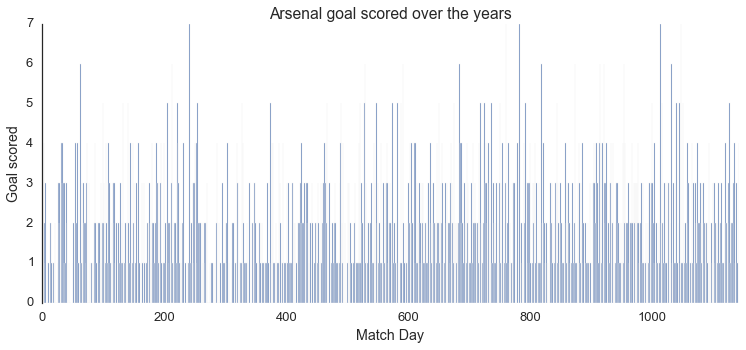

In [477]:
plt.figure(figsize=(12.5, 5))
gscored = arsenalDf.gscored.tolist()
sample_count = len(gscored)
print sample_count
plt.bar(np.arange(sample_count), gscored)
plt.xlabel("Match Day")
plt.ylabel("Goal scored")
plt.title("Arsenal goal scored over the years")
plt.xlim(0, sample_count);

sns.despine(bottom=True)

In [478]:
alpha = 1.0 / np.mean(gscored)  
                               
lambda_1 = pm.Exponential("lambda_1", 1/1.5)
lambda_2 = pm.Exponential("lambda_2", 1/2.0)

tau = pm.DiscreteUniform("tau", lower=0, upper=sample_count)

In [479]:
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(sample_count)
    out[:tau] = lambda_1  # lambda before tau is lambda1
    out[tau:] = lambda_2  # lambda after (and including) tau is lambda2
    return out

In [480]:
observation = pm.Poisson("obs", lambda_, value=gscored, observed=True)

model = pm.Model([observation, lambda_1, lambda_2, tau])

In [464]:
mcmc = pm.MCMC(model)
mcmc.sample(500000, 15000, 1)

 [-----------------100%-----------------] 500000 of 500000 complete in 165.2 sec

In [465]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

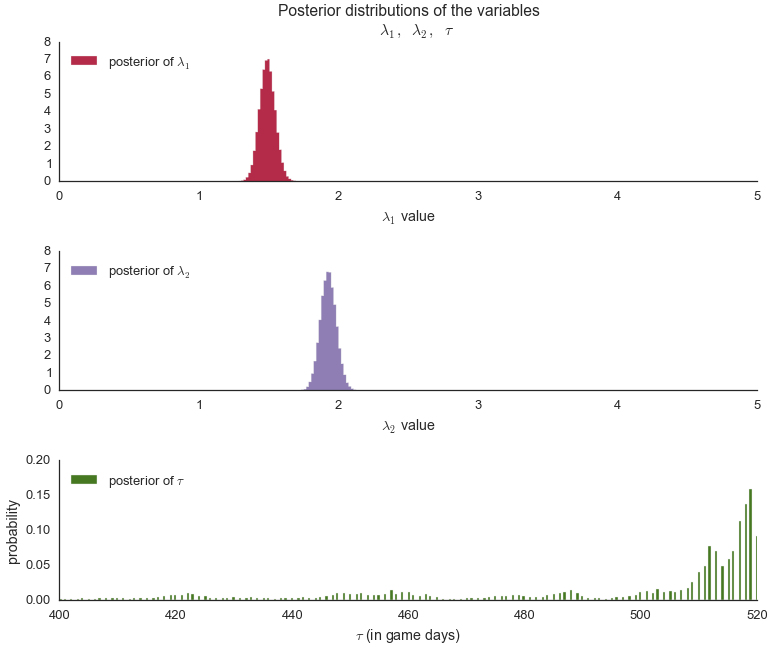

In [489]:
plt.figure(figsize=(12.5, 10))

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([0, 5])
plt.ylim([0, 8])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([0, 5])
plt.ylim([0, 8])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=sample_count, alpha=1,
         label=r"posterior of $\tau$", normed=True,
         color="#467821", weights=w, rwidth=2.)

plt.legend(loc="upper left")
plt.ylim([0, .2])
plt.xlim([400, 520])
plt.xlabel(r"$\tau$ (in game days)")
plt.ylabel("probability")
sns.despine()

In [493]:
print arsenalDf.iloc[521]

Date        1999-02-20 00:00:00
Season                     1998
home                    Arsenal
visitor          Leicester City
FT                          5-0
hgoal                         5
vgoal                         0
division                      1
tier                          1
totgoal                       5
goaldif                       5
result                        H
gdiff                         5
gscored                       5
gconc                         5
Name: 155492, dtype: object


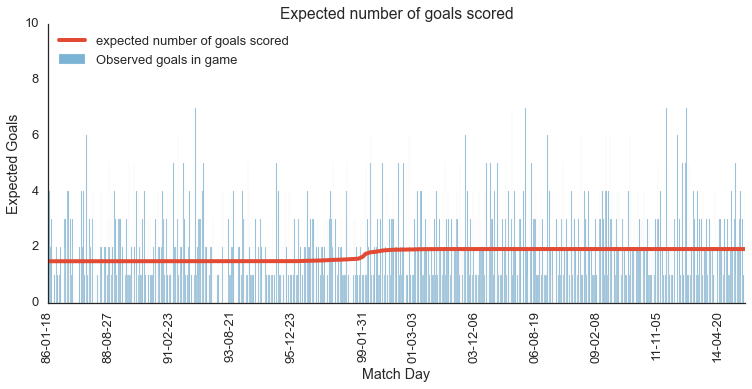

In [468]:
plt.figure(figsize=(12.5, 5))

N = tau_samples.shape[0]
expected_goals_per_game = np.zeros(sample_count)
for day in range(0, sample_count):
    
    ix = day < tau_samples
    expected_goals_per_game[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(sample_count), expected_goals_per_game, lw=4, color="#E24A33",
         label="expected number of goals scored")
plt.xlim(0, sample_count)
plt.xlabel("Match Day")
plt.ylabel("Expected Goals")
plt.title("Expected number of goals scored")
plt.ylim(0, 10)
plt.bar(np.arange(len(gscored)), gscored, color="#348ABD", alpha=0.65,
        label="Observed goals in game")
xticksAt = [0, 100, 200, 300, 400, 518, 600, 700, 800, 900, 1000, 1100]
dates = arsenalDf.Date.tolist()
xtickValues = [datetime.datetime.strftime(dates[i], '%y-%m-%d') for i in xticksAt]
plt.xticks(xticksAt, xtickValues, rotation=90)
plt.legend(loc="upper left");
sns.despine()

[ 0.          0.04040404  0.08080808  0.12121212  0.16161616  0.2020202
  0.24242424  0.28282828  0.32323232  0.36363636  0.4040404   0.44444444
  0.48484848  0.52525253  0.56565657  0.60606061  0.64646465  0.68686869
  0.72727273  0.76767677  0.80808081  0.84848485  0.88888889  0.92929293
  0.96969697  1.01010101  1.05050505  1.09090909  1.13131313  1.17171717
  1.21212121  1.25252525  1.29292929  1.33333333  1.37373737  1.41414141
  1.45454545  1.49494949  1.53535354  1.57575758  1.61616162  1.65656566
  1.6969697   1.73737374  1.77777778  1.81818182  1.85858586  1.8989899
  1.93939394  1.97979798  2.02020202  2.06060606  2.1010101   2.14141414
  2.18181818  2.22222222  2.26262626  2.3030303   2.34343434  2.38383838
  2.42424242  2.46464646  2.50505051  2.54545455  2.58585859  2.62626263
  2.66666667  2.70707071  2.74747475  2.78787879  2.82828283  2.86868687
  2.90909091  2.94949495  2.98989899  3.03030303  3.07070707  3.11111111
  3.15151515  3.19191919  3.23232323  3.27272727  3.3

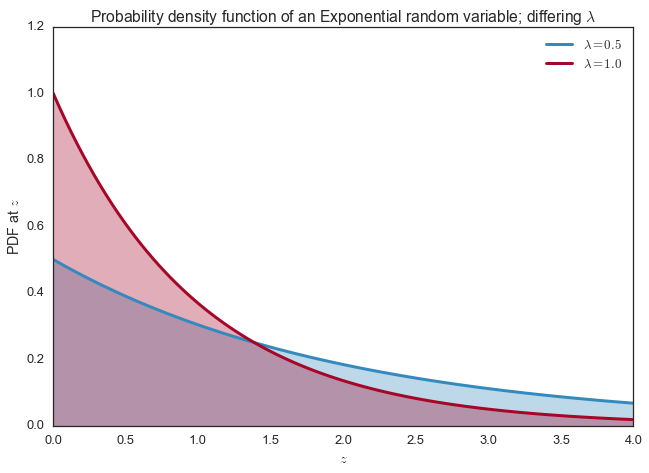

In [469]:
a = np.linspace(0, 4, 100)
print a
expo = stats.expon
lambda_ = [0.5, 1]

for l, c in zip(lambda_, colours):
    plt.plot(a, expo.pdf(a, scale=1. / l), lw=3,
             color=c, label="$\lambda = %.1f$" % l)
    plt.fill_between(a, expo.pdf(a, scale=1. / l), color=c, alpha=.33)

plt.legend()
plt.ylabel("PDF at $z$")
plt.xlabel("$z$")
plt.ylim(0, 1.2)
plt.title("Probability density function of an Exponential random variable;\
 differing $\lambda$");

In [460]:
print np.mean(lambda_1_samples), np.mean(lambda_2_samples)

 1.49032708074 1.92725076242
